In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =1

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

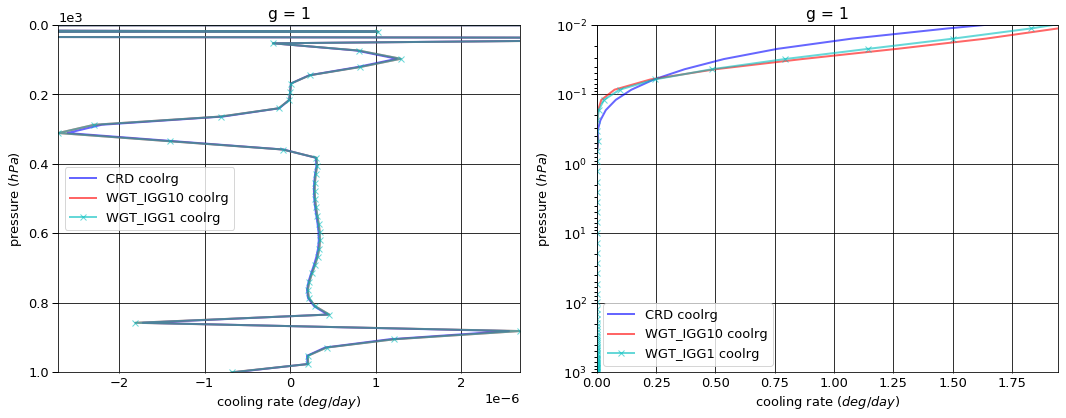

# Figure: cooling rate g-group 2

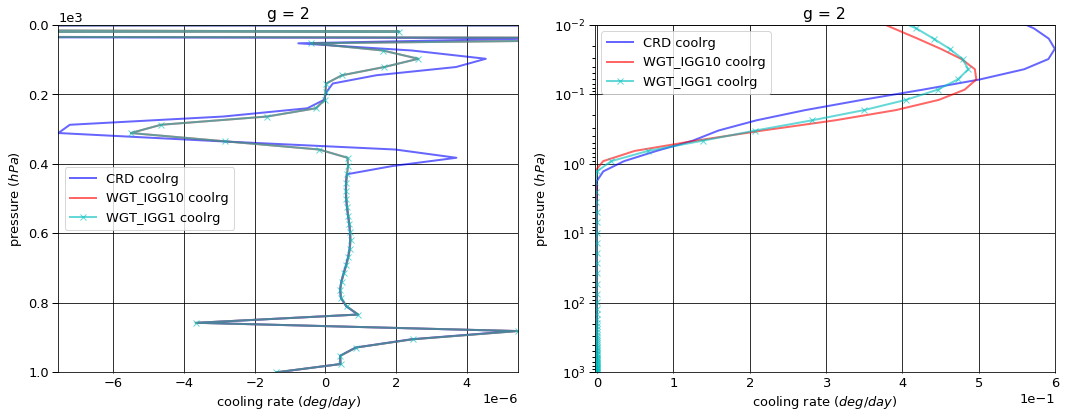

# Figure: cooling rate g-group 3

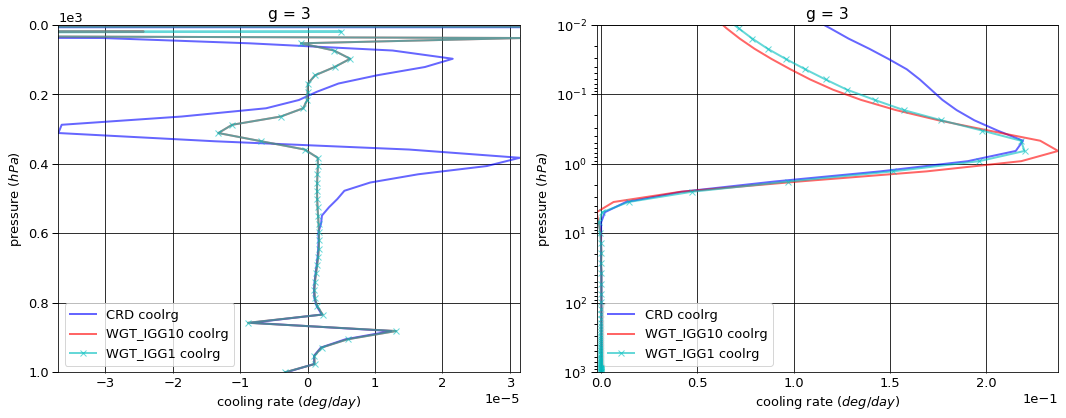

# Figure: cooling rate g-group 4

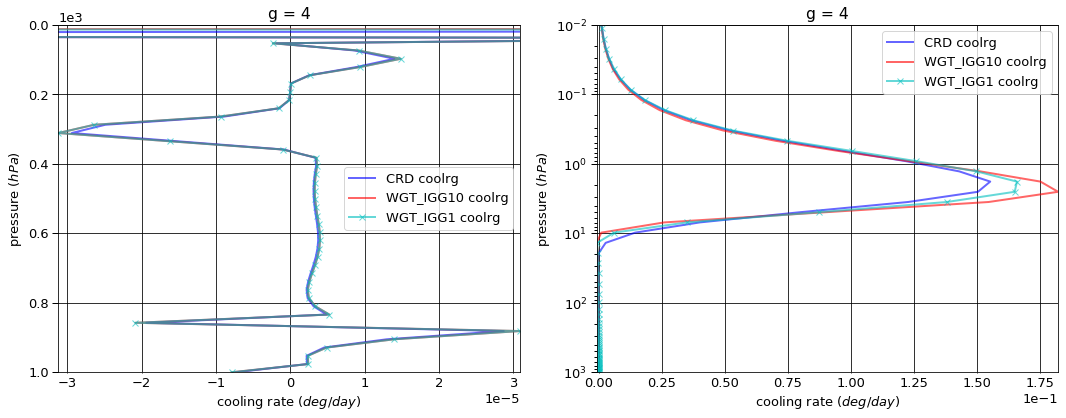

# Figure: cooling rate g-group 5

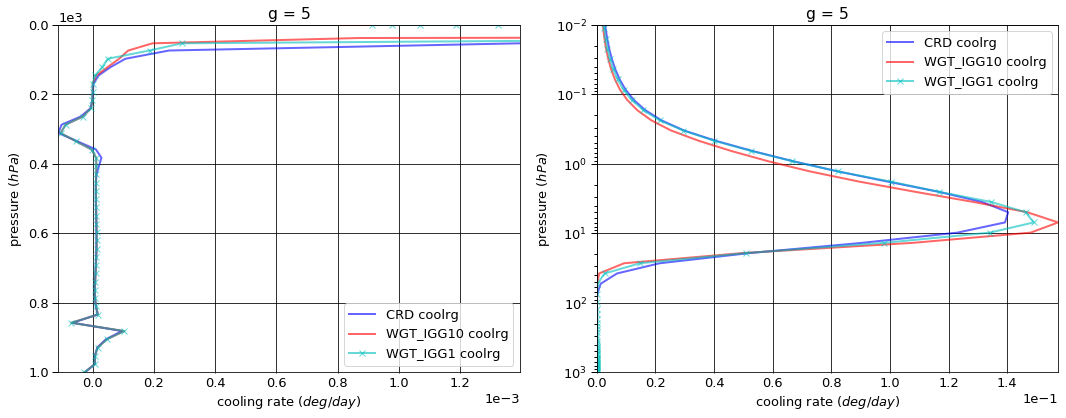

# Figure: cooling rate g-group 6

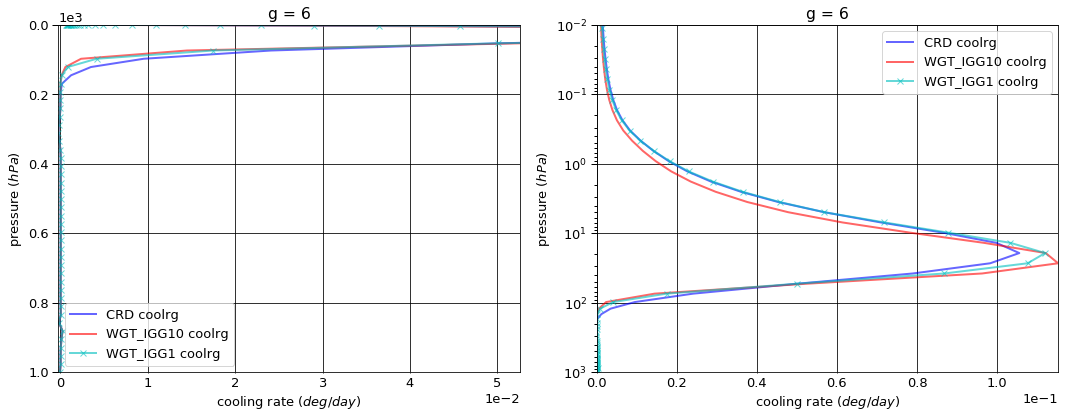

# Figure: cooling rate g-group 7

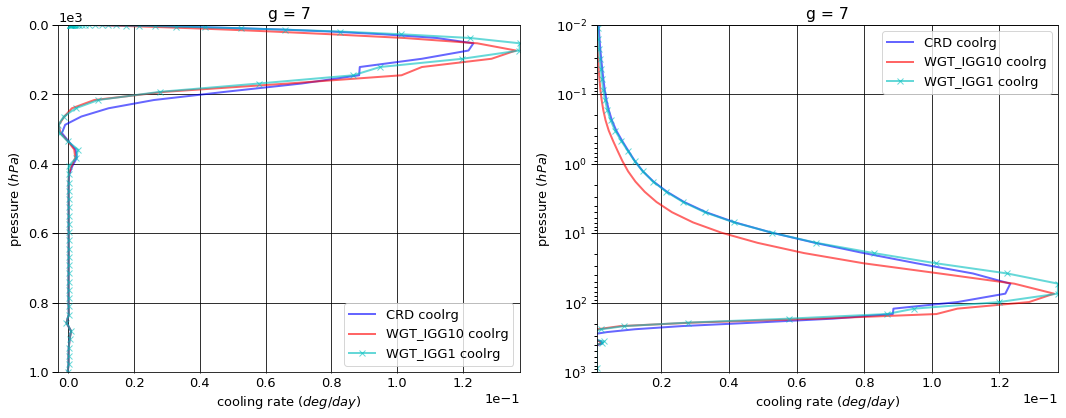

# Figure: cooling rate g-group 8

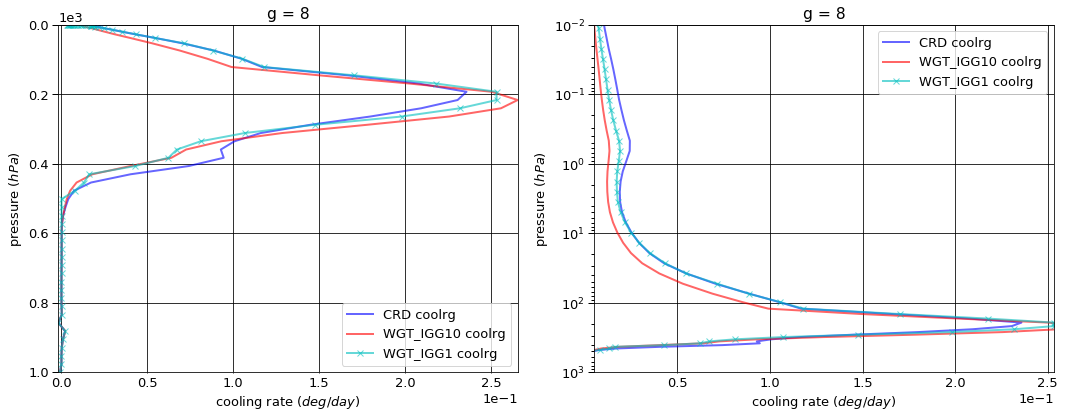

# Figure: cooling rate g-group 9

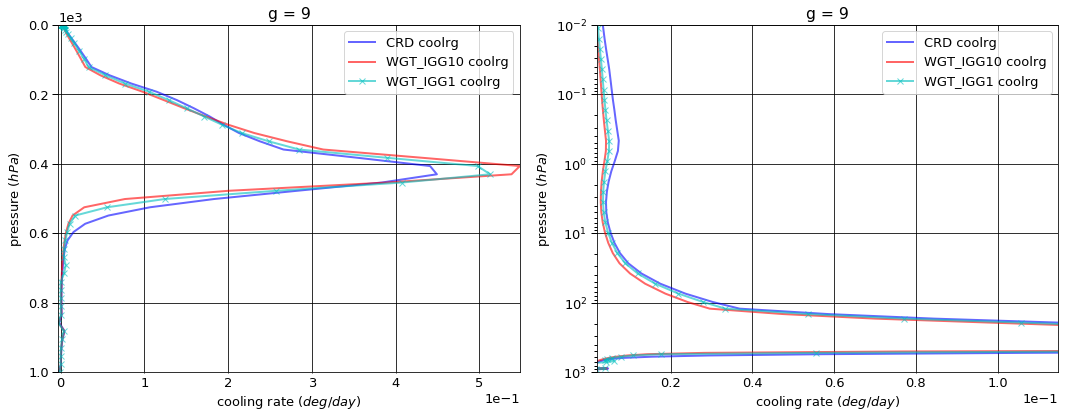

# Figure: cooling rate g-group 10

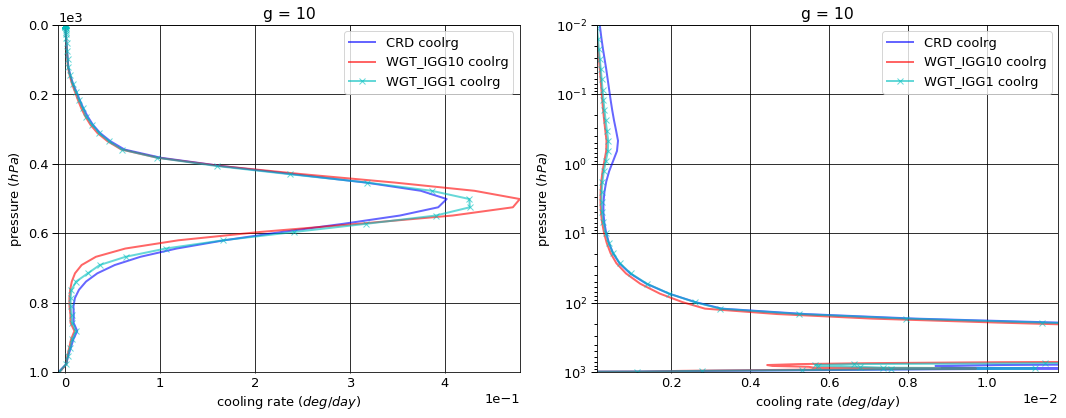

# Figure: cooling rate g-group total

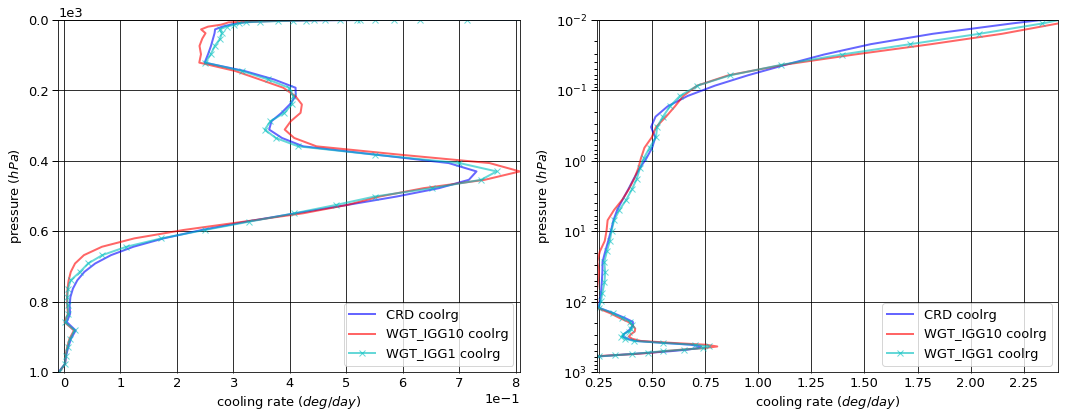

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008384   0.000000  -0.008384
   1013.0   76     -0.009922   0.009924   0.000002
2  0.0      1      -0.019192   0.000000  -0.019192
   1013.0   76     -0.020199   0.020204   0.000005
3  0.0      1      -0.044775   0.000000  -0.044775
   1013.0   76     -0.048502   0.048513   0.000011
4  0.0      1      -0.094326   0.000000  -0.094326
   1013.0   76     -0.114123   0.114148   0.000025
5  0.0      1      -0.287653   0.000000  -0.287653
   1013.0   76     -0.381874   0.381958   0.000084
6  0.0      1      -0.652434   0.000000  -0.652434
   1013.0   76     -0.896578   0.896775   0.000198
7  0.0      1      -2.287980   0.000000  -2.287980
   1013.0   76     -3.115571   3.116259   0.000689
8  0.0      1      -6.663324   0.000000  -6.663324
   1013.0   76     -8.925444   8.927440   0.001997
9  0.0      1     -11.547037   0.000000 -11.547037
   1013.0   76    -14.600303  14.606467   0.006164
10 0.0      1     -10.340870   0.000000 -10.340870
   1013.0   76    -12.148954  12.181340   0.032386


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008390   0.000000  -0.008390
   1013.0   76     -0.009946   0.009949   0.000002
2  0.0      1      -0.019370   0.000000  -0.019370
   1013.0   76     -0.020211   0.020216   0.000005
3  0.0      1      -0.045150   0.000000  -0.045150
   1013.0   76     -0.048623   0.048635   0.000012
4  0.0      1      -0.094485   0.000000  -0.094485
   1013.0   76     -0.114488   0.114515   0.000027
5  0.0      1      -0.282902   0.000000  -0.282902
   1013.0   76     -0.383219   0.383310   0.000091
6  0.0      1      -0.635711   0.000000  -0.635711
   1013.0   76     -0.899762   0.899975   0.000213
7  0.0      1      -2.241383   0.000000  -2.241383
   1013.0   76     -3.126744   3.127485   0.000741
8  0.0      1      -6.518546   0.000000  -6.518546
   1013.0   76     -8.952518   8.954641   0.002123
9  0.0      1     -11.368192   0.000000 -11.368192
   1013.0   76    -14.623415  14.628204   0.004788
10 0.0      1     -10.400200   0.000000 -10.400200
   1013.0   76    -12.082542  12.106193   0.023651


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008374   0.000000  -0.008374
   1013.0   76     -0.009946   0.009949   0.000002
2  0.0      1      -0.019374   0.000000  -0.019374
   1013.0   76     -0.020211   0.020216   0.000005
3  0.0      1      -0.044756   0.000000  -0.044756
   1013.0   76     -0.048623   0.048635   0.000012
4  0.0      1      -0.094060   0.000000  -0.094060
   1013.0   76     -0.114488   0.114515   0.000027
5  0.0      1      -0.283121   0.000000  -0.283121
   1013.0   76     -0.383219   0.383310   0.000091
6  0.0      1      -0.637020   0.000000  -0.637020
   1013.0   76     -0.899762   0.899975   0.000213
7  0.0      1      -2.238335   0.000000  -2.238335
   1013.0   76     -3.126744   3.127485   0.000741
8  0.0      1      -6.513575   0.000000  -6.513575
   1013.0   76     -8.952518   8.954641   0.002123
9  0.0      1     -11.403893   0.000000 -11.403893
   1013.0   76    -14.623415  14.626883   0.003467
10 0.0      1     -10.445709   0.000000 -10.445709
   1013.0   76    -12.082542  12.111311   0.028769


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1     -0.000005  0.000000 -5.440200e-06
   1013.0   76    -0.000025  0.000025  1.106636e-07
2  0.0      1     -0.000177  0.000000 -1.774050e-04
   1013.0   76    -0.000012  0.000012  8.250050e-08
3  0.0      1     -0.000375  0.000000 -3.750020e-04
   1013.0   76    -0.000121  0.000122  6.283020e-07
4  0.0      1     -0.000160  0.000000 -1.595250e-04
   1013.0   76    -0.000365  0.000367  1.889753e-06
5  0.0      1      0.004752  0.000000  4.751760e-03
   1013.0   76    -0.001345  0.001352  6.481608e-06
6  0.0      1      0.016723  0.000000  1.672260e-02
   1013.0   76    -0.003184  0.003200  1.561912e-05
7  0.0      1      0.046597  0.000000  4.659700e-02
   1013.0   76    -0.011173  0.011226  5.242671e-05
8  0.0      1      0.144779  0.000000  1.447785e-01
   1013.0   76    -0.027074  0.027200  1.260239e-04
9  0.0      1      0.178845  0.000000  1.788450e-01
   1013.0   76    -0.023112  0.021737 -1.375633e-03
10 0.0      1     -0.059330  0.000000 -5.933000e-02
   1013.0   76     0.066412 -0.075147 -8.734820e-03


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000010  0.000000  9.719500e-06
   1013.0   76    -0.000025  0.000025  1.106636e-07
2  0.0      1     -0.000182  0.000000 -1.815630e-04
   1013.0   76    -0.000012  0.000012  8.250050e-08
3  0.0      1      0.000019  0.000000  1.897400e-05
   1013.0   76    -0.000121  0.000122  6.283020e-07
4  0.0      1      0.000266  0.000000  2.656200e-04
   1013.0   76    -0.000365  0.000367  1.889753e-06
5  0.0      1      0.004533  0.000000  4.532680e-03
   1013.0   76    -0.001345  0.001352  6.481608e-06
6  0.0      1      0.015414  0.000000  1.541404e-02
   1013.0   76    -0.003184  0.003200  1.561912e-05
7  0.0      1      0.049645  0.000000  4.964460e-02
   1013.0   76    -0.011173  0.011226  5.242671e-05
8  0.0      1      0.149749  0.000000  1.497493e-01
   1013.0   76    -0.027074  0.027200  1.260239e-04
9  0.0      1      0.143144  0.000000  1.431440e-01
   1013.0   76    -0.023112  0.020416 -2.696573e-03
10 0.0      1     -0.104839  0.000000 -1.048390e-01
   1013.0   76     0.066412 -0.070029 -3.617388e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.319128e+00
   1001.112500 75    -6.528382e-07
2  0.000312    1      2.674763e-01
   1001.112500 75    -1.367985e-06
3  0.000312    1      5.349380e-02
   1001.112500 75    -3.166028e-06
4  0.000312    1      3.409586e-05
   1001.112500 75    -7.335164e-06
5  0.000312    1      1.171511e-03
   1001.112500 75    -2.450758e-05
6  0.000312    1      7.027939e-04
   1001.112500 75    -5.742440e-05
7  0.000312    1      6.131115e-04
   1001.112500 75    -2.000944e-04
8  0.000312    1      4.894804e-03
   1001.112500 75    -5.795531e-04
9  0.000312    1      1.659143e-03
   1001.112500 75    -1.763124e-03
10 0.000312    1      5.393805e-05
   1001.112500 75    -7.222832e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      1.961974e+00
   1001.112500 75    -6.850406e-07
2  0.000312    1      1.633633e-01
   1001.112500 75    -1.391995e-06
3  0.000312    1      2.807377e-02
   1001.112500 75    -3.348834e-06
4  0.000312    1      3.049646e-05
   1001.112500 75    -7.885112e-06
5  0.000312    1      8.046508e-04
   1001.112500 75    -2.639350e-05
6  0.000312    1      5.433712e-04
   1001.112500 75    -6.196939e-05
7  0.000312    1      3.470807e-04
   1001.112500 75    -2.153486e-04
8  0.000312    1      2.548952e-03
   1001.112500 75    -6.165877e-04
9  0.000312    1      8.857106e-04
   1001.112500 75    -1.380965e-03
10 0.000312    1      3.243459e-05
   1001.112500 75    -6.108560e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      2.462922e+00
   1001.112500 75    -6.850406e-07
2  0.000312    1      1.873042e-01
   1001.112500 75    -1.391995e-06
3  0.000312    1      3.060352e-02
   1001.112500 75    -3.348834e-06
4  0.000312    1      3.232687e-05
   1001.112500 75    -7.885112e-06
5  0.000312    1      9.119978e-04
   1001.112500 75    -2.639350e-05
6  0.000312    1      6.676016e-04
   1001.112500 75    -6.196939e-05
7  0.000312    1      4.953039e-04
   1001.112500 75    -2.153486e-04
8  0.000312    1      3.646177e-03
   1001.112500 75    -6.165877e-04
9  0.000312    1      1.056886e-03
   1001.112500 75    -1.007160e-03
10 0.000312    1      3.709755e-05
   1001.112500 75    -6.857673e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.357154e+00
   1001.112500 75    -3.220239e-08
2  0.000312    1     -1.041129e-01
   1001.112500 75    -2.400970e-08
3  0.000312    1     -2.542003e-02
   1001.112500 75    -1.828064e-07
4  0.000312    1     -3.599394e-06
   1001.112500 75    -5.499477e-07
5  0.000312    1     -3.668604e-04
   1001.112500 75    -1.885919e-06
6  0.000312    1     -1.594227e-04
   1001.112500 75    -4.544998e-06
7  0.000312    1     -2.660308e-04
   1001.112500 75    -1.525413e-05
8  0.000312    1     -2.345852e-03
   1001.112500 75    -3.703467e-05
9  0.000312    1     -7.734327e-04
   1001.112500 75     3.821582e-04
10 0.000312    1     -2.150345e-05
   1001.112500 75     1.114272e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.856205e+00
   1001.112500 75    -3.220239e-08
2  0.000312    1     -8.017207e-02
   1001.112500 75    -2.400970e-08
3  0.000312    1     -2.289027e-02
   1001.112500 75    -1.828064e-07
4  0.000312    1     -1.768989e-06
   1001.112500 75    -5.499477e-07
5  0.000312    1     -2.595134e-04
   1001.112500 75    -1.885919e-06
6  0.000312    1     -3.519229e-05
   1001.112500 75    -4.544998e-06
7  0.000312    1     -1.178076e-04
   1001.112500 75    -1.525413e-05
8  0.000312    1     -1.248627e-03
   1001.112500 75    -3.703467e-05
9  0.000312    1     -6.022577e-04
   1001.112500 75     7.559634e-04
10 0.000312    1     -1.684050e-05
   1001.112500 75     3.651592e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.945976,0.000000,-31.945976
1013.0,76,-40.261468,40.303029,0.041561



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.614328,0.000000,-31.614328
1013.0,76,-40.261468,40.293122,0.031654



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.688218,0.000000,-31.688218
1013.0,76,-40.261468,40.296919,0.035451



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.316475e-01,0.000000,0.331647
1013.0,76,3.366000e-07,-0.009907,-0.009907



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.577584e-01,0.00000,0.257758
1013.0,76,3.366000e-07,-0.00611,-0.006111


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.649227
1001.112500,75,-0.009860



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.158603
1001.112500,75,-0.008423



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.687678
1001.112500,75,-0.008798



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.490624
1001.112500,75,0.001437



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.961550
1001.112500,75,0.001062


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000266,0.000247
2,0.000500,0.000502
3,0.001391,0.001208
4,0.003156,0.002844
5,0.011406,0.009518
6,0.025547,0.022348
7,0.093094,0.077661
8,0.256141,0.222359
9,0.383641,0.363211


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.096164e-16
2,1.309690e-17
3,1.564810e-18
4,4.601703e-18
5,5.682550e-19
6,6.154553e-19
7,7.853808e-20
8,1.002222e-20
9,1.278933e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.096164e-16,NaN,0.000266,0.000247,0.000266,0.000247,1.0
2,1.309690e-17,0.119479,0.000500,0.000502,0.000766,0.000749,1.0
3,1.564810e-18,0.119479,0.001391,0.001208,0.002156,0.001957,1.0
4,4.601703e-18,2.940742,0.003156,0.002844,0.005313,0.004800,30.0
5,5.682550e-19,0.123488,0.011406,0.009518,0.016719,0.014319,30.0
6,6.154553e-19,1.083062,0.025547,0.022348,0.042266,0.036667,300.0
7,7.853808e-20,0.127610,0.093094,0.077661,0.135359,0.114328,300.0
8,1.002222e-20,0.127610,0.256141,0.222359,0.391500,0.336687,300.0
9,1.278933e-21,0.127610,0.383641,0.363211,0.775141,0.699898,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     3.522970e-16  1.449404e-16   2.430634  1.764091e-02
      2  0.000312     1.283292e-17  7.985365e-18   1.607055  8.038899e-04
      3  0.000312     1.135494e-18  4.105303e-19   2.765920  5.348285e-05
      4  0.000312     2.350940e-22  2.349597e-22   1.000572  2.001287e-08
      5  0.000312     2.455697e-21  1.364734e-21   1.799396  1.440946e-07
      6  0.000312     5.996396e-22  4.465088e-22   1.342951  4.193744e-08
      7  0.000312     1.389735e-22  5.422769e-23   2.562778  8.948323e-09
      8  0.000312     4.338664e-22  3.478267e-23  12.473635  2.335399e-08
      9  0.000312     8.404718e-23  3.984337e-24  21.094397  4.430257e-09
      10 0.000312     3.987377e-24  3.502065e-25  11.385789  2.156714e-10
2     1  0.000750     3.549857e-16  1.460107e-16   2.431230  7.158891e-03
      2  0.000750     1.318814e-17  8.137707e-18   1.620621  3.311095e-04
      3  0.000750     1.152845e-18  4.192644e-19   2.749685  2.193045e-05
      4  0.000750     4.699035e-22  4.697595e-22   1.000306  1.611507e-08
      5  0.000750     2.522843e-21  1.420446e-21   1.776092  6.006808e-08
      6  0.000750     6.125233e-22  4.554993e-22   1.344730  1.724029e-08
      7  0.000750     1.431761e-22  5.569374e-23   2.570775  3.710874e-09
      8  0.000750     4.412258e-22  3.530813e-23  12.496437  9.565349e-09
      9  0.000750     8.557431e-23  4.057711e-24  21.089307  1.816885e-09
      10 0.000750     4.176504e-24  3.569952e-25  11.699049  9.085512e-11
3     1  0.001052     3.603502e-16  1.480830e-16   2.433434  1.018672e-02
      2  0.001052     1.391803e-17  8.431196e-18   1.650778  4.847590e-04
      3  0.001052     1.187631e-18  4.347802e-19   2.731567  3.177942e-05
      4  0.001052     6.334741e-22  6.333177e-22   1.000247  3.046757e-08
      5  0.001052     2.624639e-21  1.498207e-21   1.751853  8.832612e-08
      6  0.001052     6.347842e-22  4.695702e-22   1.351841  2.497261e-08
      7  0.001052     1.514741e-22  5.804179e-23   2.609743  5.488760e-09
      8  0.001052     4.567356e-22  3.623924e-23  12.603343  1.387988e-08
      9  0.001052     8.879868e-23  4.191451e-24  21.185667  2.643611e-09
      10 0.001052     4.585263e-24  3.698890e-25  12.396321  1.394599e-10
4     1  0.001476     3.656937e-16  1.501963e-16   2.434772  1.449888e-02
      2  0.001476     1.468715e-17  8.729988e-18   1.682379  7.097506e-04
      3  0.001476     1.225317e-18  4.511611e-19   2.715919  4.611989e-05
      4  0.001476     8.627105e-22  8.625343e-22   1.000204  5.821184e-08
      5  0.001476     2.743185e-21  1.590371e-21   1.724871  1.306658e-07
      6  0.001476     6.585748e-22  4.846972e-22   1.358734  3.623012e-08
      7  0.001476     1.606957e-22  6.066552e-23   2.648880  8.144352e-09
      8  0.001476     4.736660e-22  3.722487e-23  12.724449  2.018410e-08
      9  0.001476     9.228148e-23  4.331279e-24  21.305825  3.853497e-09
      10 0.001476     5.040780e-24  3.836878e-25  13.137713  2.144640e-10
5     1  0.002070     3.709406e-16  1.523292e-16   2.435124  2.062626e-02
      2  0.002070     1.548735e-17  9.030985e-18   1.714912  1.038153e-03
      3  0.002070     1.265760e-18  4.683781e-19   2.702432  6.697633e-05
      4  0.002070     1.184153e-21  1.183943e-21   1.000177  1.120707e-07
      5  0.002070     2.881828e-21  1.699903e-21   1.695289  1.944644e-07
      6  0.002070     6.839796e-22  5.010764e-22   1.365020  5.262253e-08
      7  0.002070     1.708497e-22  6.361555e-23   2.685659  1.211152e-08
      8  0.002070     4.919628e-22  3.826657e-23  12.856204  2.938852e-08
      9  0.002070     9.600201e-23  4.476927e-24  21.443731  5.621677e-09
      10 0.002070     5.542316e-24  3.983761e-25  13.912270  3.298439e-10
6     1  0.002904     3.760835e-16  1.544887e-16   2.434376  2.933880e-02
      2  0.002904     1.631964e-17  9.335224e-18   1.748179  1.517685e-03
      3  0.002904     1.309288e

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
